In [38]:
# !wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

Data preparation
Check if the missing values are presented in the features.
If there are missing values:
For caterogiral features, replace them with 'NA'
For numerical features, replace with with 0.0
Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [40]:
df = pd.read_csv("course_lead_scoring.csv")
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [41]:
df.isna().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [42]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [43]:
df['lead_source'] = df['lead_source'].fillna('NA')
df['industry'] = df['industry'].fillna('NA')
df['employment_status'] = df['employment_status'].fillna('NA')
df['location'] = df['location'].fillna('NA')

df['annual_income'] = df['annual_income'].fillna(0)

In [44]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(
    df_full_train, test_size=0.25, random_state=1)

y_train = df_train['converted'].values
del df_train['converted']

y_val = df_val['converted'].values
del df_val['converted']

y_test = df_test['converted'].values
del df_test['converted']

Question 1: ROC AUC feature importance
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
Use the training dataset for that
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['balance'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

lead_score
number_of_courses_viewed
interaction_count
annual_income

In [45]:
from sklearn.metrics import roc_auc_score

In [46]:
categorical = ['lead_source', 'industry', 'employment_status', 'location']
numerical = ['number_of_courses_viewed',
             'annual_income', 'interaction_count', 'lead_score']
label = 'converted'

In [47]:
for col in numerical:
    auc = roc_auc_score(y_train, df_train[col].values)
    print(f"{col}: {auc}")

number_of_courses_viewed: 0.7635680590007088
annual_income: 0.5519578313253012
interaction_count: 0.738270176293409
lead_score: 0.6144993577250176


Question 2: Training the model
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
What's the AUC of this model on the validation dataset? (round to 3 digits)

0.32
0.52
0.72
0.92

In [48]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [49]:
dv = DictVectorizer(sparse=False)


def prepare_data(df_train, df_val):
    train_dict = df_train.to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)

    val_dict = df_val.to_dict(orient='records')
    X_val = dv.transform(val_dict)

    return X_train, X_val

In [50]:
X_train, X_val = prepare_data(df_train, df_val)

model = LogisticRegression(solver='liblinear', C=1.0,
                           max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:, 1]
round(roc_auc_score(y_val, y_pred), 3)

0.817

Question 3: Precision and Recall
Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
For each threshold, compute precision and recall
Plot them
At which threshold precision and recall curves intersect?

0.145
0.345
0.545
0.745

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

In [52]:
probs = model.predict_proba(X_val)[:, 1]

thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []

for t in thresholds:
    preds = (probs >= t).astype(int)
    precisions.append(precision_score(y_val, preds, zero_division=0))
    recalls.append(recall_score(y_val, preds))

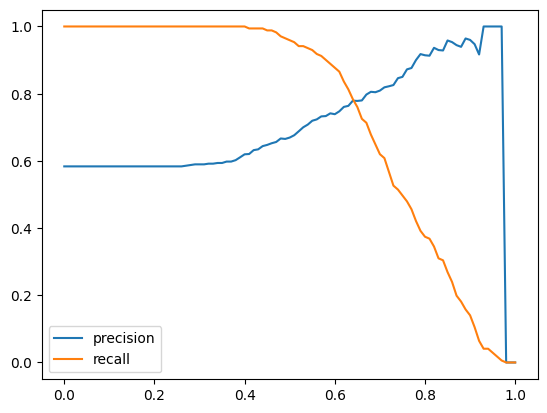

In [53]:
plt.plot(thresholds, precisions, label='precision')
plt.plot(thresholds, recalls, label='recall')
plt.legend()

Question 4: F1 score
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F
1
=
2
⋅
P
⋅
R
P
+
R

Where 
P
 is precision and 
R
 is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

0.14
0.34
0.54
0.74

In [54]:
from sklearn.metrics import f1_score

f1_scores = []
for t in thresholds:
    preds = (probs >= t).astype(int)
    f1_scores.append(f1_score(y_val, preds))

idx = np.asarray(f1_scores).argmax()
thresholds[idx]

np.float64(0.5700000000000001)

Question 5: 5-Fold CV
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)
Iterate over different folds of df_full_train
Split the data into train and validation
Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
Use AUC to evaluate the model on validation
How large is standard deviation of the scores across different folds?

0.0001
0.006
0.06
0.36

In [55]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train[numerical + categorical].iloc[train_idx]
    df_val = df_full_train[numerical + categorical].iloc[val_idx]

    y_train = df_full_train[label].iloc[train_idx].values
    y_val = df_full_train[label].iloc[val_idx].values

    X_train, X_val = prepare_data(df_train, df_val)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    probs = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, probs)
    scores.append(score)


print("Standard Deviation: ", np.std(scores))

Standard Deviation:  0.03580711942905165


Question 6: Hyperparameter Tuning
Now let's use 5-Fold cross-validation to find the best parameter C

Iterate over the following C values: [0.000001, 0.001, 1]
Initialize KFold with the same parameters as previously
Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
Compute the mean score as well as the std (round the mean and std to 3 decimal digits)
Which C leads to the best mean score?

0.000001
0.001
1
If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.

In [56]:
from tqdm.auto import tqdm

for C in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train[numerical + categorical].iloc[train_idx]
        df_val = df_full_train[numerical + categorical].iloc[val_idx]

        y_train = df_full_train[label].iloc[train_idx].values
        y_val = df_full_train[label].iloc[val_idx].values

        X_train, X_val = prepare_data(df_train, df_val)

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)

        probs = model.predict_proba(X_val)[:, 1]
        score = roc_auc_score(y_val, probs)
        scores.append(score)

    print('C=%f Mean: %.3f  STD: %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/3 [00:00<?, ?it/s]

C=0.000001 Mean: 0.560  STD: 0.024
C=0.001000 Mean: 0.867  STD: 0.029
C=1.000000 Mean: 0.822  STD: 0.036
